# Analysis of Fitbit Data

This is an analysis of my Fitbit data that I have collected using my Charge HR since Feb 2015. I look at 


Some of the project goals:
* Is there a correlation to when I go to bed and how well I sleep?
* Is there any pattern to my waking up at night? For example, x hours after I sleep or every y hours, etc?
* Is there a correlation to how well I sleep vs how much I have walked?
* Is there a pattern to the number of steps I walk vs the day of the week?
* Is there a pattern to the number of steps I walk vs time of day?
* Has the number of hours of restful sleep I have been getting constant over the last few months or has it varied a lot?

Other goals:
* Learn how to use an API and oauth to download data in Python
* Improve on my skills using Python and the other Python libraries

In [373]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
% matplotlib inline
import seaborn as sns
import fitbit
from datetime import timedelta
import csv
import sys, os
from collections import deque

## Obtain new data using the Fitbit API and write data to csv.


In [305]:
# Function to get the latest Fitbit data from the API.

def get_latest_fitbit_data(authd_client, last_log_date, yesterday):
    
    last_log_date_str = datetime.strftime(last_log_date,"%Y-%m-%d")
    yesterday_str = datetime.strftime(yesterday,"%Y-%m-%d")
    
    # Retrieve time series data by accessing Fitbit API. 
    # Note that the last logged date is the first date because data only upto yesterday gets written into csv.
    # Today is not over, hence incomplete data from today is not logged.

    steps = authd_client.time_series('activities/steps', base_date= last_log_date_str ,end_date=yesterday_str)
    cals = authd_client.time_series('activities/calories', base_date= last_log_date_str ,end_date=yesterday_str)
    dist = authd_client.time_series('activities/distance', base_date= last_log_date_str ,end_date=yesterday_str)
    floors = authd_client.time_series('activities/floors', base_date= last_log_date_str ,end_date=yesterday_str)
    sedant = authd_client.time_series('activities/minutesSedentary', base_date= last_log_date_str ,end_date=yesterday_str)
    elevation = authd_client.time_series('activities/elevation', base_date= last_log_date_str ,end_date=yesterday_str)
    active_light = authd_client.time_series('activities/minutesLightlyActive', base_date= last_log_date_str ,end_date=yesterday_str)
    active_fair = authd_client.time_series('activities/minutesFairlyActive', base_date= last_log_date_str ,end_date=yesterday_str)
    active_very = authd_client.time_series('activities/minutesVeryActive', base_date= last_log_date_str ,end_date=yesterday_str)
    active_cals = authd_client.time_series('activities/activityCalories', base_date= last_log_date_str ,end_date=yesterday_str)
    sleep_start = authd_client.time_series('sleep/startTime', base_date= last_log_date_str ,end_date=yesterday_str)
    sleep_timeInBed = authd_client.time_series('sleep/timeInBed', base_date= last_log_date_str ,end_date=yesterday_str)
    sleep_minutesAsleep = authd_client.time_series('sleep/minutesAsleep', base_date= last_log_date_str ,end_date=yesterday_str)
    sleep_awakeningsCount = authd_client.time_series('sleep/awakeningsCount', base_date= last_log_date_str ,end_date=yesterday_str)
    sleep_minutesAwake = authd_client.time_series('sleep/minutesAwake', base_date= last_log_date_str ,end_date=yesterday_str)
    sleep_minutesToFallAsleep = authd_client.time_series('sleep/minutesToFallAsleep', base_date= last_log_date_str ,end_date=yesterday_str)
    sleep_minutesAfterWakeup = authd_client.time_series('sleep/minutesAfterWakeup', base_date= last_log_date_str ,end_date=yesterday_str)
    sleep_efficiency = authd_client.time_series('sleep/efficiency', base_date= last_log_date_str ,end_date=yesterday_str)

    df = pd.DataFrame()
    num_days = yesterday - last_log_date + timedelta(1)
    date_list = [last_log_date.date() + timedelta(days=x) for x in range(0, num_days.days)]
    df['date'] = date_list
    df['calories'] = pd.DataFrame(cals['activities-calories'])['value'].astype(int)
    df['steps'] = pd.DataFrame(steps['activities-steps'])['value'].astype(int)
    df['dist'] = pd.DataFrame(dist['activities-distance'])['value'].astype(float)
    df['floors'] = pd.DataFrame(floors['activities-floors'])['value'].astype(int)
    df['elevation'] = pd.DataFrame(elevation['activities-elevation'])['value'].astype(float)
    df['sedant'] = pd.DataFrame(sedant['activities-minutesSedentary'])['value'].astype(int)
    df['active_light'] = pd.DataFrame(active_light['activities-minutesLightlyActive'])['value'].astype(int)
    df['active_fair'] = pd.DataFrame(active_fair['activities-minutesFairlyActive'])['value'].astype(int)
    df['active_very'] = pd.DataFrame(active_very['activities-minutesVeryActive'])['value'].astype(int)
    df['active_cals'] = pd.DataFrame(active_cals['activities-activityCalories'])['value'].astype(int)
    df['sleep_start'] = pd.DataFrame(sleep_start['sleep-startTime'])['value']
    df['sleep_timeInBed'] = pd.DataFrame(sleep_timeInBed['sleep-timeInBed'])['value'].astype(int)
    df['sleep_minutesAsleep'] = pd.DataFrame(sleep_minutesAsleep['sleep-minutesAsleep'])['value'].astype(int)
    df['sleep_awakeningsCount'] = pd.DataFrame(sleep_awakeningsCount['sleep-awakeningsCount'])['value'].astype(int)
    df['sleep_minutesAwake'] = pd.DataFrame(sleep_minutesAwake['sleep-minutesAwake'])['value'].astype(int)
    df['sleep_minutesToFallAsleep'] = pd.DataFrame(sleep_minutesToFallAsleep['sleep-minutesToFallAsleep'])['value'].astype(int)
    df['sleep_minutesAfterWakeup'] = pd.DataFrame(sleep_minutesAfterWakeup['sleep-minutesAfterWakeup'])['value'].astype(int)
    df['sleep_efficiency'] = pd.DataFrame(sleep_efficiency['sleep-efficiency'])['value'].astype(int)
    return df

def write_fitbit_data_to_csv(df,data_filename,log_filename):
    # Write the data frame to csv.
    with open(data_filename, 'a') as f:
        df.to_csv(f, header=False,index = False)

    # Log current date as the date last logged.
    today = datetime.today()
    today_str = datetime.strftime(today,"%Y-%m-%d")

    with open(log_filename,'ab') as csvfile:
        csvwrite = csv.writer(csvfile, delimiter=',')
        csvwrite.writerow(['Data last logged',today_str])
        
        
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n) 

def get_intraday_data(authd_client,authd_client2,start_date,end_date):
    rate_limit = 150
    df_master = pd.DataFrame()
    
    num_days = end_date - start_date
    
    # If the number of calls is going to exceed the rate limit, then change end date to last feasible date
    if num_days.days > int((rate_limit-18)/7):
        end_date = start_date + timedelta(int((rate_limit-18)/7))
        print('Date range causes rate limit to exceed')
    else:
        try:
            for single_date in daterange(start_date, end_date+timedelta(1)):
                # Create a separate dataframe for intra day data
                df_intra = pd.DataFrame(columns=['time_intra','steps_intra','calories_intra','distance_intra'\
                                                 'elevation_intra','floors_intra','date'])
                df_hr_intra = pd.DataFrame(columns=['time_intra','hr_intra'])
                df_sleep_intra = pd.DataFrame(columns=['time_intra','sleep_intra'])

                # Get intra day data using oauth client
                steps_intra = authd_client.intraday_time_series('activities/steps',base_date=single_date)
                calories_intra = authd_client.intraday_time_series('activities/calories',base_date=single_date)
                distance_intra = authd_client.intraday_time_series('activities/distance',base_date=single_date)
                elevation_intra = authd_client.intraday_time_series('activities/elevation',base_date=single_date)
                floors_intra = authd_client.intraday_time_series('activities/floors',base_date=single_date)

                # Intra sleep data
                sleep_intra = authd_client.get_sleep(single_date)

                # Heart rate using oauth2.0
                try:
                    hr_intra = authd_client2.intraday_time_series('activities/heart',base_date=single_date)
                except fitbit.exceptions.HTTPUnauthorized:
                    print('Please provide latest refresh and access tokens for oauth2. Exiting program.')
                    sys.exit(1)
                 
                # Temperory pandas dataframes hold all the data before being merged to one big dataframe
                df_intra['time_intra'] = pd.DataFrame(steps_intra['activities-steps-intraday']['dataset'])['time']
                df_intra['steps_intra'] = pd.DataFrame(steps_intra['activities-steps-intraday']['dataset'])['value'].astype(int)
                df_intra['calories_intra'] = pd.DataFrame(calories_intra['activities-calories-intraday']['dataset'])['value'].astype(int)
                df_intra['distance_intra'] = pd.DataFrame(distance_intra['activities-distance-intraday']['dataset'])['value'].astype(float)
                df_intra['elevation_intra'] = pd.DataFrame(elevation_intra['activities-elevation-intraday']['dataset'])['value'].astype(float)
                df_intra['floors_intra'] = pd.DataFrame(floors_intra['activities-floors-intraday']['dataset'])['value'].astype(int)
                df_intra['date'] = single_date.date()
                df_hr_intra['time_intra'] = pd.DataFrame(hr_intra['activities-heart-intraday']['dataset'])['time']
                df_hr_intra['hr_intra'] = pd.DataFrame(hr_intra['activities-heart-intraday']['dataset'])['value'].astype(int)

                # Some days don't have sleep information if Fitbit was not worn before going to bed (or for other reasons)
                if not sleep_intra['sleep']:
                    print (['No sleep data for ',str(datetime.strftime(single_date,"%Y-%m-%d"))])
                else:
                    df_sleep_intra['time_intra'] = pd.DataFrame(sleep_intra['sleep'][0]['minuteData'])['dateTime']
                    df_sleep_intra['sleep_intra'] = pd.DataFrame(sleep_intra['sleep'][0]['minuteData'])['value'].astype(int)

                # Merge the two data frames into one. Note the reason for doing it this way is because the heart rate data does not necessarily 
                # have all the minutes. Whenever the Fitbit has been removed and kept aside, no HR data was collected 
                df_intra = pd.merge(df_intra,df_hr_intra, how='left', on='time_intra',
                      left_index=False, right_index=False, sort=False,
                      suffixes=('_x', '_y'), copy=True)

                df_intra = pd.merge(df_intra,df_sleep_intra, how='left', on='time_intra',
                      left_index=False, right_index=False, sort=False,
                      suffixes=('_x', '_y'), copy=True)

                # Concatenate to master dataframe
                df_master = pd.concat([df_master,df_intra], ignore_index = True)
        except fitbit.exceptions.HTTPTooManyRequests:
            print('Rate limit reached. Rerun program after 1 hour. Exiting program.')
            sys.exit(1)
            
    return df_master


def obtain_write_new_data:
    # Get Fitbit User keys and secrets from csv file
    auth_keys = dict()
    with open('Data/access_tokens.csv','r') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        for row in csv_reader:
            auth_keys[row[0]] = row[1]

    # Create an oauth and oauth2 client 
    authd_client = fitbit.Fitbit(auth_keys['consumer_key'], auth_keys['consumer_secret'], resource_owner_key =auth_keys['user_key'], resource_owner_secret =auth_keys['user_secret'])
    authd_client2 = fitbit.Fitbit(auth_keys['client_id'], auth_keys['client_secret'], oauth2=True, access_token=auth_keys['access_token'], refresh_token=auth_keys['refresh_token'])

    # Read log file to find out the last day Fitbit data was logged
    with open('Data/Data_log_dates.csv') as csvfile:
        temp = deque(csv.reader(csvfile), 1)[0]

    # Get yesterday's date and last logged date in both datetime format and in string format
    # Data from today is incomplete and not logged. So we are interested in yesterday's date.

    last_log_date = datetime.strptime(temp[1],"%Y-%m-%d")
    today = datetime.today()
    yesterday = today - timedelta(days=1) 

    # Get latest fitbit daily data
    df = get_latest_fitbit_data(authd_client,last_log_date,yesterday)

    # Add latest daily data to daily data csv file
    write_fitbit_data_to_csv(df,'Data/Daily_Fitbit_Data.csv','Data/Data_log_dates.csv')

    # Get latest intraday data
    # Read log file to find out the last day Fitbit data was logged
    with open('Data/Data_log_dates_intraday.csv') as csvfile:
        temp = deque(csv.reader(csvfile), 1)[0]
    last_log_date = datetime.strptime(temp[1],"%Y-%m-%d")

    # Get intraday data for all days from last_log_date to yesterday
    df_master = get_intraday_data(authd_client,authd_client2,last_log_date,yesterday)

    # Add latest daily intra day data to daily data csv file
    write_fitbit_data_to_csv(df_master,'Data/Intraday_data.csv','Data/Data_log_dates_intraday.csv')

## Analysis of data written to csv file

The data written to a csv file is read and analyzed.

In [374]:
# Read the daily data from csv
df = pd.read_csv('Data/Daily_Fitbit_Data.csv')
df.head(3)

,date,calories,steps,dist,floors,elevation,sedant,active_light,active_fair,active_very,active_cals,sleep_start,sleep_timeInBed,sleep_minutesAsleep,sleep_awakeningsCount,sleep_minutesAwake,sleep_minutesToFallAsleep,sleep_minutesAfterWakeup,sleep_efficiency
0,2015-02-21,2342,7514,3.198626,11,110,717,255,14,2,1043,22:34,511,451,29,50,0,6,90
1,2015-02-22,2022,3262,1.388671,2,20,761,161,5,5,634,23:33,424,379,26,38,0,1,91
2,2015-02-23,2281,8537,3.634002,14,140,805,188,24,8,932,23:31,424,416,5,5,0,0,99


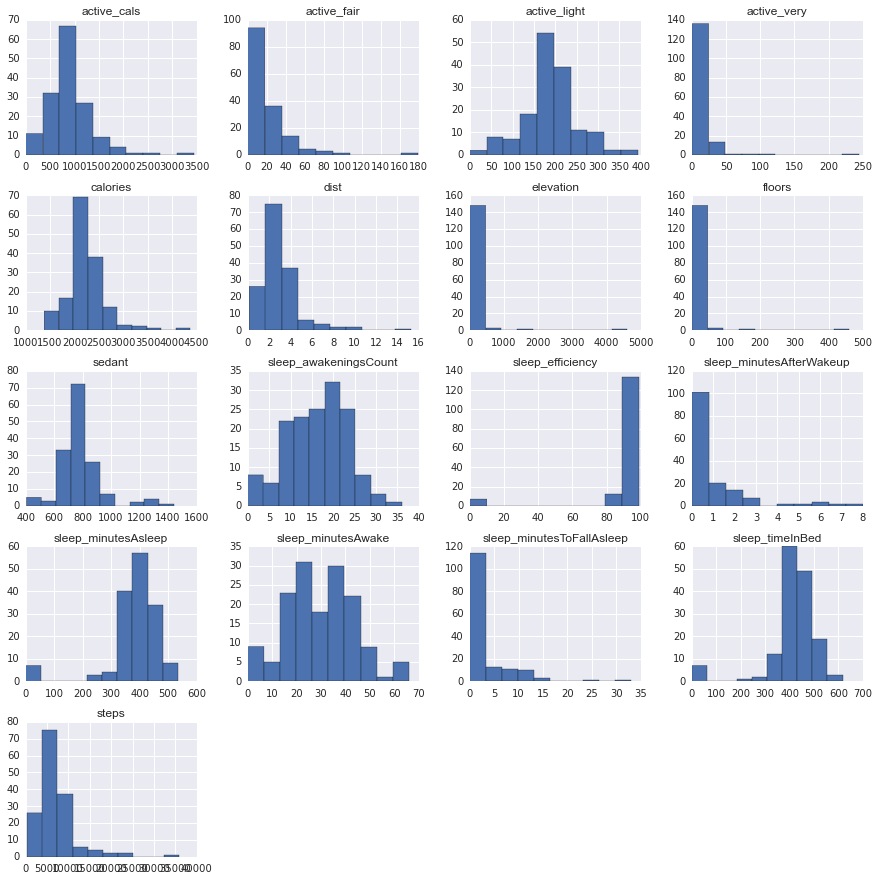

In [375]:
# Looking at the distributions corresponding to each numerical variable in the raw data
h = df.hist(figsize = (15,15))

# Data wrangling

In [376]:
# Data cleaning and manipulation

# Create a weekday label which says which day of the week we are looking at.
df['weekday'] = df['date'].map(lambda x: (datetime.strptime(str(x),"%Y-%m-%d")).weekday() , na_action = 'ignore')
df['day'] = df['date'].map(lambda x: (datetime.strptime(str(x),"%Y-%m-%d")).date , na_action = 'ignore')
df['month'] = df['date'].map(lambda x: (datetime.strptime(str(x),"%Y-%m-%d")).month , na_action = 'ignore')
# df['sleep_awakenings_per'] = df['sleep_awakeningsCount']/df['sleep_timeInBed']*60*100

# Percentage of awake time to time in bed (related to efficiency)
df['sleep_minutes_awake_per'] = df['sleep_minutesAwake']/df['sleep_timeInBed']*100 

# Sleep start hour. 
df['sleep_start_hr'] = df['sleep_start'].map(lambda x: (datetime.strptime(str(x),"%H:%M")).hour+(datetime.strptime(str(x),"%H:%M")).minute/60.0, na_action = 'ignore')
# If the hour is after noon, then subtract 12 so that midnight becomes the 0 reference.

# Midnight is the baseline so that hours can be either + or - from midnight
ind = df[df['sleep_start_hr'] > 12.0].index.tolist()
df['sleep_start_hr'].iloc[ind] = df['sleep_start_hr'].iloc[ind] - 24.0

#Waking up time
df['wake_hour'] = df['sleep_start_hr']+df['sleep_timeInBed']/60



In [384]:
# Function to clean up plots
def prepare_plot_area(ax):
    # Remove plot frame lines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False) 
    
    # X and y ticks on bottom and left
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    
# Defining a color pattern that is pleasing
colrcode = [(31, 119, 180), (255, 127, 14),\
             (44, 160, 44), (214, 39, 40), \
             (148, 103, 189),  (140, 86, 75), \
             (227, 119, 194), (127, 127, 127), \
             (188, 189, 34), (23, 190, 207)]

for i in range(len(colrcode)):  
    r, g, b = colrcode[i]  
    colrcode[i] = (r / 255., g / 255., b / 255.)

## Exploratory Data Analysis

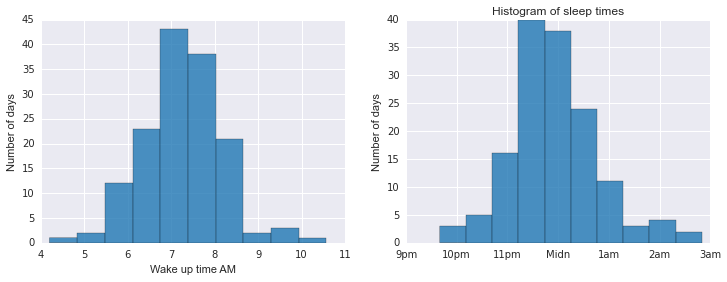

In [381]:
fig,axes = plt.subplots(figsize = (12,4),nrows = 1, ncols = 2)
plt.sca(axes[0])
h = df['wake_hour'].hist(color = colrcode[0], alpha = 0.8)
plt.xlabel('Wake up time AM')
plt.ylabel('Number of days')

plt.sca(axes[1])
df['sleep_start_hr'].plot(kind = 'hist',color = colrcode[0], alpha = 0.8)
xt = plt.xticks([-3,-2,-1,0,1,2,3],['9pm','10pm','11pm','Midn','1am','2am','3am'])
tt = plt.title('Histogram of sleep times')
yy = plt.ylabel('Number of days')

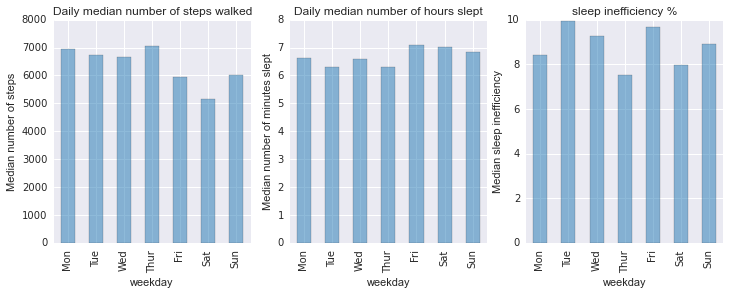

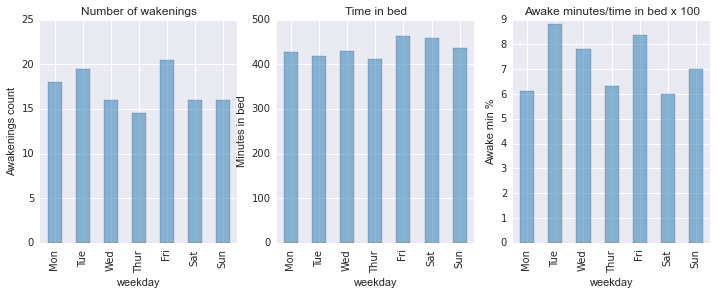

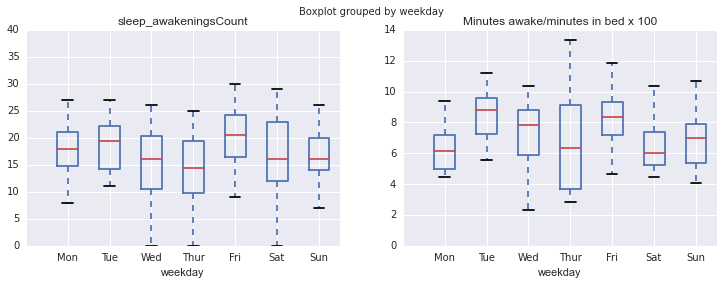

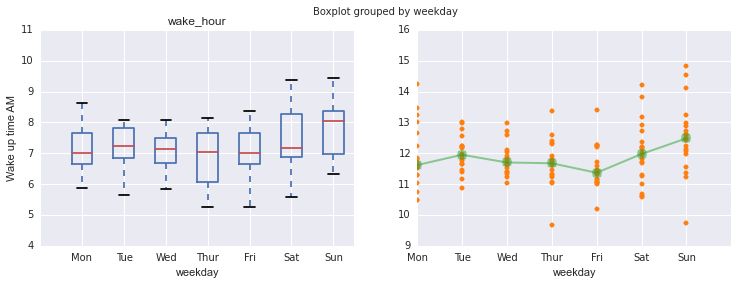

In [388]:
# Looking at variations based on weekday

weekday_stps = df['steps'].groupby(df['weekday']).median()
sleep_minutes_asleep_med = df['sleep_minutesAsleep'].groupby(df['weekday']).median()/60
sl_eff = (1-df['sleep_minutesAsleep']/df['sleep_timeInBed'])*100
sl = sl_eff.groupby(df['weekday']).median()
wak = df['sleep_awakeningsCount'].groupby(df['weekday']).median()
sl_minutes_inbed = df['sleep_timeInBed'].groupby(df['weekday']).median()
awkmin_per = df['sleep_minutes_awake_per'].groupby(df['weekday']).median()

# Median number of steps
fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ct = 0
plt.sca(axes[ct])
weekday_stps.plot(kind = 'bar',color = colrcode[0], alpha = 0.5)
plt.ylabel('Median number of steps')
plt.title('Daily median number of steps walked')
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
prepare_plot_area(axes[ct])

# Median number of minutes slept
ct +=1
plt.sca(axes[ct])
sleep_minutes_asleep_med.plot(kind = 'bar',color = colrcode[0], alpha = 0.5)
plt.ylabel('Median number of minutes slept')
plt.title('Daily median number of hours slept')
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
prepare_plot_area(axes[ct])

ct +=1
plt.sca(axes[ct])
sl.plot(kind = 'bar',color = colrcode[0], alpha = 0.5)
plt.ylabel('Median sleep inefficiency')
plt.title('sleep inefficiency %')
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
prepare_plot_area(axes[ct])

fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ct =0
plt.sca(axes[ct])
wak.plot(kind = 'bar',color = colrcode[0], alpha = 0.5)
plt.ylabel('Awakenings count')
plt.title('Number of wakenings')
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
prepare_plot_area(axes[ct])

ct += 1
plt.sca(axes[ct])
sl_minutes_inbed.plot(kind = 'bar',color = colrcode[0], alpha = 0.5)
plt.ylabel('Minutes in bed')
plt.title('Time in bed')
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
prepare_plot_area(axes[ct])

ct += 1
plt.sca(axes[ct])
awkmin_per.plot(kind = 'bar',color = colrcode[0], alpha = 0.5)
plt.ylabel('Awake min %')
plt.title('Awake minutes/time in bed x 100')
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
prepare_plot_area(axes[ct])


fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plt.sca(axes[0])
d = df.boxplot(column='sleep_awakeningsCount', by='weekday', ax =axes[0])
d = plt.xticks(list(range(8)),['','Mon','Tue','Wed','Thur','Fri','Sat','Sun'])

plt.sca(axes[1])
d = df.boxplot(column='sleep_minutes_awake_per', by='weekday', ax =axes[1])
d = plt.xticks(list(range(8)),['','Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.title('Minutes awake/minutes in bed x 100')

fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plt.sca(axes[0])
h = df.boxplot(column= 'wake_hour', by = 'weekday', ax = axes[0])
h = plt.xticks(list(range(8)),['','Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
h = plt.ylabel('Wake up time AM')

sl_hr = df['sleep_start_hr'].groupby(df['weekday']).median()+12
plt.sca(axes[1])
sl_hr.plot(kind = 'line',color = colrcode[2],alpha = 0.5,linewidth = 2, marker = 'o',markersize = 10)
d = plt.xticks(list(range(8)),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.scatter(df['weekday'],df['sleep_start_hr']+12, color = colrcode[1])

plt.ylim = (9,15)


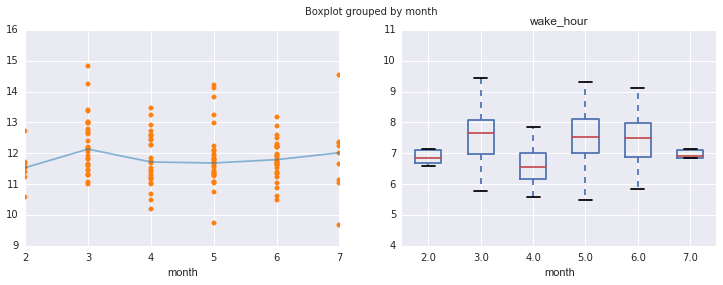

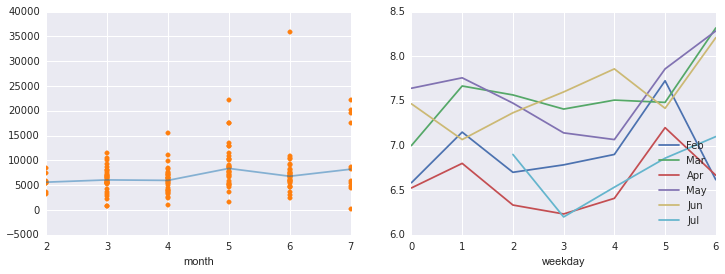

In [361]:
# Looking at variations across months

sl_st_mon = df['sleep_start_hr'].groupby(df['month']).median()+12
fig,axes = plt.subplots(figsize = (12,4), nrows = 1, ncols = 2)
plt.sca(axes[0])
sl_st_mon.plot(kind = 'line', color = colrcode[0], alpha = 0.5)
plt.scatter(df['month'],df['sleep_start_hr']+12, color = colrcode[1])

plt.sca(axes[1])
d = df.boxplot(column='wake_hour', by='month', ax =axes[1])

st_mon = df['steps'].groupby(df['month']).median()
fig,axes = plt.subplots(figsize = (12,4), nrows = 1, ncols = 2)
plt.sca(axes[0])
st_mon.plot(kind = 'line', color = colrcode[0], alpha = 0.5)
plt.scatter(df['month'],df['steps'], color = colrcode[1])

plt.sca(axes[1])
d = df.groupby(['month','weekday'])['wake_hour'].median()
weekdays = ['Feb','Mar','Apr','May','Jun','Jul','Aug']
for i in range(2,8):
    d[i].plot(kind = 'line',label = weekdays[i-2])
h = plt.legend(loc='lower right')





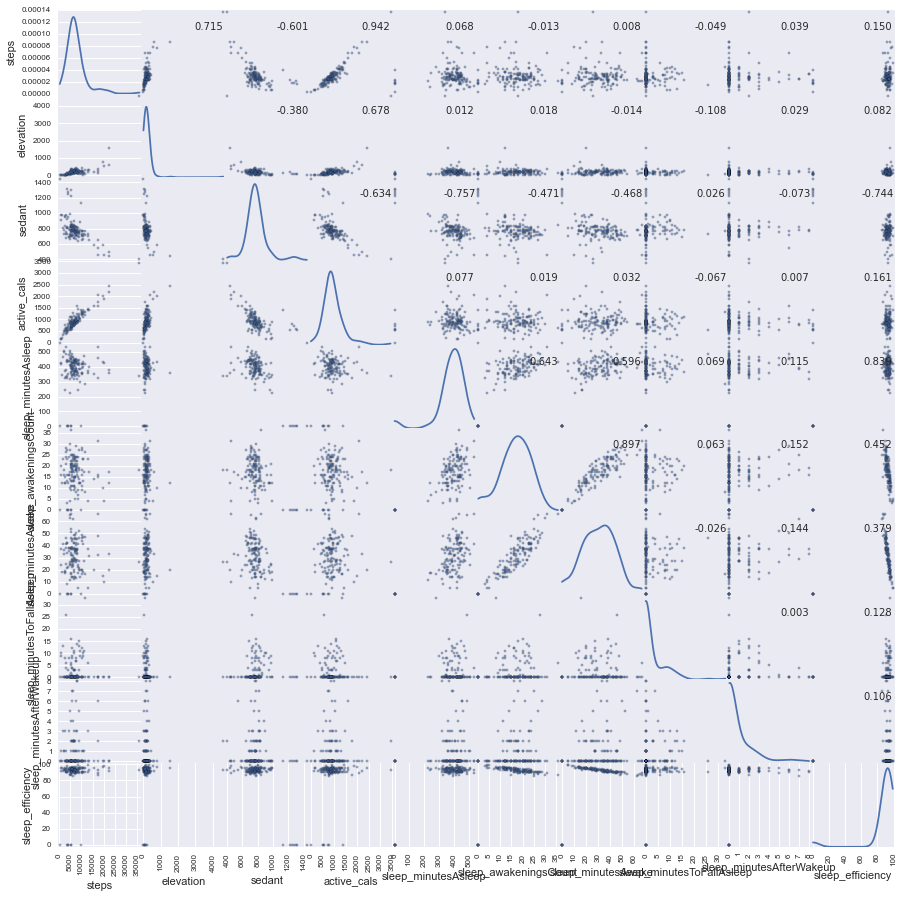

In [292]:
df_subset = df[['steps','elevation','sedant','active_cals','sleep_minutesAsleep','sleep_awakeningsCount',\
                     'sleep_minutesAwake','sleep_minutesToFallAsleep','sleep_minutesAfterWakeup','sleep_efficiency']]
 
axes = pd.scatter_matrix(df_subset, figsize = (15,15), alpha=0.5, diagonal='kde')

corr = df_subset.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')


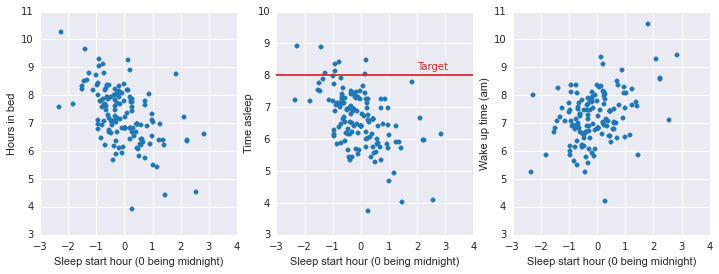

In [399]:
# Looking at trends in the data 

fig,axes = plt.subplots(figsize = (12,4), nrows = 1, ncols = 3)
plt.sca(axes[0])
h = plt.scatter(df['sleep_start_hr'],df['sleep_timeInBed']/60,color = colrcode[0])
plt.xlabel('Sleep start hour (0 being midnight)')
plt.ylabel('Hours in bed')

plt.sca(axes[1])
h = plt.scatter(df['sleep_start_hr'],df['sleep_minutesAsleep']/60,color = colrcode[0])
plt.xlabel('Sleep start hour (0 being midnight)')
plt.ylabel('Time asleep')
plt.axhline(y=8,color = colrcode[3])
plt.text(2,8.2,'Target',color = colrcode[3])

plt.sca(axes[2])
h = plt.scatter(df['sleep_start_hr'],df['wake_hour'],color = colrcode[0])
plt.xlabel('Sleep start hour (0 being midnight)')
plt.ylabel('Wake up time (am)')

* The hours of sleep are inveresely proportional to the sleep start hour i.e. later I sleep, the less sleep I get.
* But the later I sleep, the later I wake up as well. However this is not a very strong trend, especially if you remove points that constitute data when I slept really early or slept really late.
* I haven't got my target 8 hours of sleep if I haven't slept at or before midnight.
* I have had minimum 7 hours sleep if I have slept at or before 11 pm.
